In [153]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author:Unknown

Functional autoencoder implementation
"""

# Import modules
import inspect
import random
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
from tqdm import tqdm
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [154]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
# plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
# plt.show(
# )
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
# plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
# plt.show(

# )
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
# plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
# plt.show(
# )


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
# plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
# plt.show(
# )
grid_points=ElNino_OISST_region_1and2_x
T=len(grid_points)

c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

In [155]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

labels = torch.tensor([0] * x0.shape[0] + [1] * x1.shape[0] + [2] * x2.shape[0] + [3] * x3.shape[0]).unsqueeze(1).unsqueeze(2).cuda()
X=torch.concatenate([x0,x1,x2,x3]).reshape(148,1,12)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
x_train.shape,y_train.shape



(torch.Size([111, 1, 12]), torch.Size([111, 1, 1]))

In [156]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.07)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.07)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [157]:
n_epochs=25  
basis=B(knots=linspace(1,T,6),order=3)
n_conv_out=64
granulation=1200
n_conv_in=128
n_conv_in2=128
n_conv_in3=64
n_Flat_out=256
stride_1=6
stride_2=2
stride_3=1
stride_pool_1=2
stride_pool_2=2
stride_pool_3=1
kernel_size_1=120
kernel_size_2=35
kernel_size_3=20
kernel_size_pool_1=6
kernel_size_pool_2=4
kernel_size_pool_3=2
dilation_1=1
dilation_2=1
dilation_3=1
dilation_pool_1=1
dilation_pool_2=1
dilation_pool_3=1
padding_1=2
padding_2=2
padding_3=2
padding_pool_1=1
padding_pool_2=1
padding_pool_3=1
opt="Adam"
lr_adam=0.00089
lr_SGD=0.001
loss_function=nn.CrossEntropyLoss()
batch_size=96

In [158]:
class HyperParameters:
    def __init__(self, n_epochs=25, basis=B(knots=linspace(1, T, 6), order=3), granulation=2000,
                 n_conv_in=128, n_conv_in2=128, n_conv_in3=64,n_conv_out=64, n_Flat_out=256,
                 stride_1=6, stride_2=2, stride_3=1,
                 stride_pool_1=2, stride_pool_2=2, stride_pool_3=1,
                 kernel_size_1=200, kernel_size_2=50, kernel_size_3=20,
                 kernel_size_pool_1=6, kernel_size_pool_2=4, kernel_size_pool_3=2,
                 dilation_1=1, dilation_2=1, dilation_3=1,
                 dilation_pool_1=1, dilation_pool_2=1, dilation_pool_3=1,
                 padding_1=2, padding_2=2, padding_3=2,
                 padding_pool_1=1, padding_pool_2=1, padding_pool_3=1,
                 opt="Adam", lr=0.00089, loss=nn.CrossEntropyLoss(),activation=nn.Identity()):
        self.n_epochs = n_epochs
        self.activation=activation
        self.n_conv_out=n_conv_out
        self.basis = basis
        self.granulation = granulation
        self.n_conv_in = n_conv_in
        self.n_conv_in2 = n_conv_in2
        self.n_conv_in3 = n_conv_in3
        self.n_Flat_out = n_Flat_out
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.stride_3 = stride_3
        self.stride_pool_1 = stride_pool_1
        self.stride_pool_2 = stride_pool_2
        self.stride_pool_3 = stride_pool_3
        self.kernel_size_1 = kernel_size_1
        self.kernel_size_2 = kernel_size_2
        self.kernel_size_3 = kernel_size_3
        self.kernel_size_pool_1 = kernel_size_pool_1
        self.kernel_size_pool_2 = kernel_size_pool_2
        self.kernel_size_pool_3 = kernel_size_pool_3
        self.dilation_1 = dilation_1
        self.dilation_2 = dilation_2
        self.dilation_3 = dilation_3
        self.dilation_pool_1 = dilation_pool_1
        self.dilation_pool_2 = dilation_pool_2
        self.dilation_pool_3 = dilation_pool_3
        self.padding_1 = padding_1
        self.padding_2 = padding_2
        self.padding_3 = padding_3
        self.padding_pool_1 = padding_pool_1
        self.padding_pool_2 = padding_pool_2
        self.padding_pool_3 = padding_pool_3
        self.opt = opt
        self.lr = lr
        self.loss = loss


In [159]:
arguments_defaults = {
    "n_epochs": 25,
    "basis": B(knots=linspace(1,T,6),order=3),
    "granulation": 1200,
    "n_conv_in": 128,
    "n_conv_in2": 128,
    "n_conv_in3": 64,
    "n_Flat_out": 256,
    "stride_1": 6,
    "stride_2": 2,
    "stride_3": 1,
    "stride_pool_1": 2,
    "stride_pool_2": 2,
    "stride_pool_3": 1,
    "kernel_size_1": 120,
    "kernel_size_2": 50,
    "kernel_size_3": 20,
    "kernel_size_pool_1": 6,
    "kernel_size_pool_2": 4,
    "kernel_size_pool_3": 2,
    "dilation_1": 1,
    "dilation_2": 1,
    "dilation_3": 1,
    "dilation_pool_1": 1,
    "dilation_pool_2": 1,
    "dilation_pool_3": 1,
    "padding_1": 2,
    "padding_2": 2,
    "padding_3": 2,
    "padding_pool_1": 1,
    "padding_pool_2": 1,
    "padding_pool_3": 1,
    "opt": "Adam",
    "lr": 0.00089,
    "loss": nn.CrossEntropyLoss()
}


In [160]:
Defaults_arguments=HyperParameters()


In [181]:

class Smooth_Strides_FCNN(nn.Module):
    def __init__(self, hyperparams):
        super(Smooth_Strides_FCNN, self).__init__()

        basis = hyperparams.basis
        granulation = hyperparams.granulation
        n_conv_in = hyperparams.n_conv_in
        n_conv_in2 = hyperparams.n_conv_in2
        n_conv_in3 = hyperparams.n_conv_in3
        n_Flat_out = hyperparams.n_Flat_out
        stride_1 = hyperparams.stride_1
        stride_2 = hyperparams.stride_2
        stride_3 = hyperparams.stride_3
        stride_pool_1 = hyperparams.stride_pool_1
        stride_pool_2 = hyperparams.stride_pool_2
        stride_pool_3 = hyperparams.stride_pool_3
        kernel_size_1 = hyperparams.kernel_size_1
        kernel_size_2 = hyperparams.kernel_size_2
        kernel_size_3 = hyperparams.kernel_size_3
        kernel_size_pool_1 = hyperparams.kernel_size_pool_1
        kernel_size_pool_2 = hyperparams.kernel_size_pool_2
        kernel_size_pool_3 = hyperparams.kernel_size_pool_3
        dilation_1 = hyperparams.dilation_1
        dilation_2 = hyperparams.dilation_2
        dilation_3 = hyperparams.dilation_3
        dilation_pool_1 = hyperparams.dilation_pool_1
        dilation_pool_2 = hyperparams.dilation_pool_2
        dilation_pool_3 = hyperparams.dilation_pool_3
        padding_1 = hyperparams.padding_1
        padding_2 = hyperparams.padding_2
        padding_3 = hyperparams.padding_3
        padding_pool_1 = hyperparams.padding_pool_1
        padding_pool_2 = hyperparams.padding_pool_2
        padding_pool_3 = hyperparams.padding_pool_3

        # Reste du code pour l'initialisation de la classe model

        self.Relu=nn.ReLU()

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer2=nn.Sequential(
            nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer3=nn.Sequential(

            nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
        )

        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
            nn.BatchNorm1d(n_Flat_out),
            nn.LeakyReLU(0.18),
            
            nn.Linear(n_Flat_out,2),
            
        )
        self.activation=nn.Softmax()
        self.n_conv_out=n_conv_out
    def Granulator(self,x):
        eval_points=linspace(1,T,granulation)
        basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
        basis_fc = torch.from_numpy(basis_eval).float().cuda()
        coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
        
        coefs_torch=torch.tensor(coefs).float().cuda()
        Recons_train=torch.matmul(coefs_torch,basis_fc)
        Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
        return Recons_train

    def forward(self,x):
        Granulated_x_train=self.Granulator(x)
        tresh_out=torch.relu(Granulated_x_train)
        Conv_out=self.convlayer1(tresh_out)
        Conv_out2=self.convlayer2(Conv_out)
        Conv_out3=self.convlayer3(Conv_out2)
        Lin_out=self.fc_block(Conv_out3)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [162]:
def Compile_class(hyperparams):
    basis = hyperparams.basis
    granulation = hyperparams.granulation
    n_conv_in = hyperparams.n_conv_in
    n_conv_in2 = hyperparams.n_conv_in2
    n_conv_in3 = hyperparams.n_conv_in3
    n_Flat_out = hyperparams.n_Flat_out
    stride_1 = hyperparams.stride_1
    stride_2 = hyperparams.stride_2
    stride_3 = hyperparams.stride_3
    stride_pool_1 = hyperparams.stride_pool_1
    stride_pool_2 = hyperparams.stride_pool_2
    stride_pool_3 = hyperparams.stride_pool_3
    kernel_size_1 = hyperparams.kernel_size_1
    kernel_size_2 = hyperparams.kernel_size_2
    kernel_size_3 = hyperparams.kernel_size_3
    kernel_size_pool_1 = hyperparams.kernel_size_pool_1
    kernel_size_pool_2 = hyperparams.kernel_size_pool_2
    kernel_size_pool_3 = hyperparams.kernel_size_pool_3
    dilation_1 = hyperparams.dilation_1
    dilation_2 = hyperparams.dilation_2
    dilation_3 = hyperparams.dilation_3
    dilation_pool_1 = hyperparams.dilation_pool_1
    dilation_pool_2 = hyperparams.dilation_pool_2
    dilation_pool_3 = hyperparams.dilation_pool_3
    padding_1 = hyperparams.padding_1
    padding_2 = hyperparams.padding_2
    padding_3 = hyperparams.padding_3
    padding_pool_1 = hyperparams.padding_pool_1
    padding_pool_2 = hyperparams.padding_pool_2
    padding_pool_3 = hyperparams.padding_pool_3

    # Reste du code de la fonction

    CNN=Smooth_Strides_FCNN(hyperparams=hyperparams).cuda()
    Granul=CNN.Granulator(x_train[:1,:,:])
    Conv_out=CNN.convlayer1(Granul)
    Conv_out2=CNN.convlayer2(Conv_out)
    Conv_out3=CNN.convlayer3(Conv_out2)
    n_conv_out=Conv_out3.shape[2]
    hyperparams.n_conv_out=n_conv_out
    class Bsp_classifier(nn.Module): 
        def __init__(self, hyperparams):
            super(Bsp_classifier, self).__init__()

            basis = hyperparams.basis
            granulation = hyperparams.granulation
            n_conv_in = hyperparams.n_conv_in
            n_conv_in2 = hyperparams.n_conv_in2
            n_conv_in3 = hyperparams.n_conv_in3
            n_conv_out=hyperparams.n_conv_out
            n_Flat_out = hyperparams.n_Flat_out
            stride_1 = hyperparams.stride_1
            stride_2 = hyperparams.stride_2
            stride_3 = hyperparams.stride_3
            stride_pool_1 = hyperparams.stride_pool_1
            stride_pool_2 = hyperparams.stride_pool_2
            stride_pool_3 = hyperparams.stride_pool_3
            kernel_size_1 = hyperparams.kernel_size_1
            kernel_size_2 = hyperparams.kernel_size_2
            kernel_size_3 = hyperparams.kernel_size_3
            kernel_size_pool_1 = hyperparams.kernel_size_pool_1
            kernel_size_pool_2 = hyperparams.kernel_size_pool_2
            kernel_size_pool_3 = hyperparams.kernel_size_pool_3
            dilation_1 = hyperparams.dilation_1
            dilation_2 = hyperparams.dilation_2
            dilation_3 = hyperparams.dilation_3
            dilation_pool_1 = hyperparams.dilation_pool_1
            dilation_pool_2 = hyperparams.dilation_pool_2
            dilation_pool_3 = hyperparams.dilation_pool_3

            self.Relu=nn.ReLU()

            self.convlayer1=nn.Sequential(
                nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer2=nn.Sequential(
                nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer3=nn.Sequential(

                nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
            )

            self.fc_block=nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
                nn.BatchNorm1d(n_Flat_out),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.Linear(n_Flat_out,4),
            )
            self.basis=basis
            self.activation=nn.Softmax()
            self.n_conv_out=n_conv_out
            self.granulation=hyperparams.granulation
        def Granulator(self,x):
            eval_points=linspace(1,T,self.granulation)
            basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
            basis_fc = torch.from_numpy(basis_eval).float().cuda()
            coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=self.basis).coefficients
            
            coefs_torch=torch.tensor(coefs).float().cuda()
            Recons_train=torch.matmul(coefs_torch,basis_fc)
            Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
            return Recons_train

        def forward(self,x):
            Granulated_x_train=self.Granulator(x)
            tresh_out=torch.relu(Granulated_x_train)
            Conv_out=self.convlayer1(tresh_out)
            Conv_out2=self.convlayer2(Conv_out)
            Conv_out3=self.convlayer3(Conv_out2)
            Lin_out=self.fc_block(Conv_out3)
            return Lin_out.float().unsqueeze_(2).unsqueeze_(3)
    module=Bsp_classifier(hyperparams=hyperparams)
    return module

In [163]:
def Compile_train(module, lr, opt="Adam", loss=nn.CrossEntropyLoss(), batch_size=batch_size):
    betas = [0.5, 0.999]
    if opt == "Adam":
        optimizer = optim.Adam(module.parameters(), lr=lr, betas=betas)
    else:
        optimizer = optim.SGD(module.parameters(), lr=lr)
    def train(n_epochs, module, optimizer, loss, batch_size):
        for epoch in range(n_epochs):
            train_loss = torch.tensor(0).cuda().long()
            
            # Mélanger les données d'entraînement
            indices = list(range(len(x_train)))
            random.shuffle(indices)
            
            batch_index = 0  # Indice de batch
            
            for i in range(int(len(x_train) / batch_size)):
                # Obtenir les indices des données mélangées
                batch_indices = indices[batch_index:batch_index+batch_size]
                
                functions_train = x_train[batch_indices,:,:]
                labels_train = y_train[batch_indices]
                
                optimizer.zero_grad()
                output = module(functions_train)
                loss_value = loss(input=output, target=labels_train)
                
                loss_value.backward()
                optimizer.step()
                train_loss += loss_value.long()
                
                batch_index += batch_size  # Passer au prochain batch
                
            return train_loss, loss_value
    
    return lambda n_epochs: train(n_epochs, module, optimizer, loss, batch_size)


In [164]:
def Hyperparameter_Test(hyperparameters):

    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
    ##Compilation de la classe 
    Model=Compile_class(hyperparams=hyperparameters).cuda().apply(weights_init_normal)
    
    
    mean_accuracy=torch.tensor([0])
    train_fn = Compile_train(module=Model, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=batch_size)
    train_fn(n_epochs=1)
    for i in tqdm(range(hyperparameters.n_epochs)):
            train_fn(n_epochs=1)
            
            accuracy=((torch.sum(torch.argmax(Model(x_test),dim=1)==y_test)/x_test.shape[0])*100)
            mean_accuracy=torch.cat([mean_accuracy,accuracy.cpu().unsqueeze(0)],dim=0)
    print("Précision moyenne =",((torch.mean(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Précision max=",((torch.max(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Variance des précisions =",((torch.var(mean_accuracy[1:].float()))).detach().cpu().numpy())  
    # print(mean_accuracy.unsqueeze(1)[1:]) 
    n_best=torch.argmax(mean_accuracy[1:])

    
    
    grid_test=fd(x_test[:,0,:].cpu(),grid_points=grid_points).to_basis(basis)
    grid_convlayer1=fd(Model.convlayer1(Model.Granulator(x_test))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer1(Model.Granulator(x_test)).shape[2]))
    grid_convlayer2=fd(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))).shape[2]))
    grid_convlayer3=fd(Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))).shape[2]))
        
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return Model,grid_convlayer1,grid_convlayer2,grid_convlayer3, mean_accuracy[1:],n_best



In [165]:
hyperparameters=HyperParameters()
hyperparameters.granulation=1200
hyperparameters.kernel_size_1=120
hyperparameters.stride_1=2
hyperparameters.n_conv_in=32
hyperparameters.n_conv_in2=512
hyperparameters.n_conv_in3=256
hyperparameters.n_epochs=50


In [166]:
Model=Compile_class(hyperparams=hyperparameters).cuda()
optimizer=optim.Adam(Model.parameters(),lr=hyperparameters.lr)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


In [167]:

FCNN,grid_convlayer1,grid_convlayer2,grid_convlayer3, Acc,n_best=Hyperparameter_Test(hyperparameters=hyperparameters)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\33423348.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 21.29it/s]


Précision moyenne = 92.00001 %
Précision max= 100.0 %
Variance des précisions = 14.000988


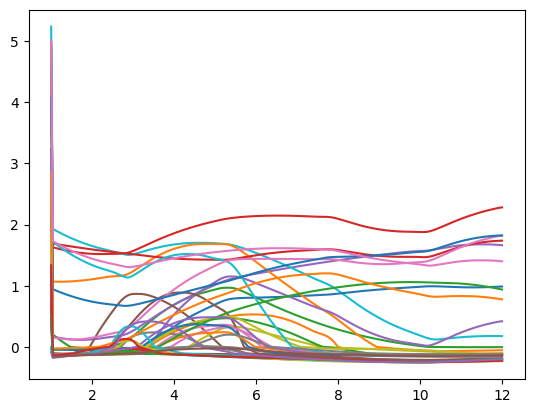

In [168]:

grid_convlayer1.plot()
plt.show()

In [169]:
def Hyper_parameter_GridSearch(hyperparams,parameter, grid):
    Total_accuracy_max = torch.tensor([0])
    Optimum_parameter = grid[0]

    
    
    # Obtenir l'attribut correspondant au paramètre spécifié
    attribute = getattr(hyperparams, parameter)
    
    for value in grid:
        # Modifier la valeur de l'attribut de la classe HyperParameters
        setattr(hyperparams, parameter, value)
        
        # Utiliser l'instance de HyperParameters pour effectuer les tests
        _, _, _, _, accuracy,n_best = Hyperparameter_Test(hyperparameters=hyperparams)
        Total_accuracy_max = torch.cat([Total_accuracy_max, torch.tensor([torch.max(accuracy)])])

    Optimum_parameter = grid[torch.argmax(Total_accuracy_max[1:])]
    return Optimum_parameter, torch.max(Total_accuracy_max[1:]),n_best


In [170]:


Hyperparameter_Test(hyperparameters=hyperparameters)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\33423348.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [00:02<00:00, 23.00it/s]


Précision moyenne = 92.43244 %
Précision max= 97.2973 %
Variance des précisions = 16.994379


(Bsp_classifier(
   (Relu): ReLU()
   (convlayer1): Sequential(
     (0): Conv1d(1, 32, kernel_size=(120,), stride=(2,), padding=(2,))
     (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.18)
     (3): Identity()
     (4): MaxPool1d(kernel_size=6, stride=2, padding=1, dilation=1, ceil_mode=False)
     (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.18)
     (7): Identity()
   )
   (convlayer2): Sequential(
     (0): Conv1d(32, 512, kernel_size=(50,), stride=(2,), padding=(2,))
     (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.18)
     (3): Identity()
     (4): MaxPool1d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
     (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.18)


In [171]:
kernel_size_Opt,Max_acc,n_best=Hyper_parameter_GridSearch(hyperparameters,grid = np.arange(25)[5:],parameter="kernel_size_3")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\33423348.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [00:01<00:00, 27.28it/s]


Précision moyenne = 92.75676 %
Précision max= 94.5946 %
Variance des précisions = 6.9885674


100%|██████████| 50/50 [00:01<00:00, 25.72it/s]


Précision moyenne = 91.89189 %
Précision max= 94.5946 %
Variance des précisions = 9.540709


100%|██████████| 50/50 [00:01<00:00, 25.47it/s]


Précision moyenne = 95.56758 %
Précision max= 97.2973 %
Variance des précisions = 6.4876876


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Précision moyenne = 94.05406 %
Précision max= 97.2973 %
Variance des précisions = 9.24256


100%|██████████| 50/50 [00:02<00:00, 24.84it/s]


Précision moyenne = 97.35135 %
Précision max= 100.0 %
Variance des précisions = 13.562702


100%|██████████| 50/50 [00:02<00:00, 24.83it/s]


Précision moyenne = 97.51352 %
Précision max= 100.0 %
Variance des précisions = 13.070756


100%|██████████| 50/50 [00:02<00:00, 24.29it/s]


Précision moyenne = 79.081085 %
Précision max= 89.189186 %
Variance des précisions = 25.88215


100%|██████████| 50/50 [00:02<00:00, 24.57it/s]


Précision moyenne = 88.162155 %
Précision max= 91.8919 %
Variance des précisions = 10.104204


100%|██████████| 50/50 [00:02<00:00, 24.25it/s]


Précision moyenne = 95.189186 %
Précision max= 97.2973 %
Variance des précisions = 10.223467


100%|██████████| 50/50 [00:02<00:00, 24.24it/s]


Précision moyenne = 88.54055 %
Précision max= 97.2973 %
Variance des précisions = 27.894644


100%|██████████| 50/50 [00:02<00:00, 23.51it/s]


Précision moyenne = 90.00001 %
Précision max= 94.5946 %
Variance des précisions = 28.994797


100%|██████████| 50/50 [00:02<00:00, 23.41it/s]


Précision moyenne = 96.486496 %
Précision max= 100.0 %
Variance des précisions = 14.98189


100%|██████████| 50/50 [00:02<00:00, 23.75it/s]


Précision moyenne = 88.75676 %
Précision max= 91.8919 %
Variance des précisions = 7.859164


100%|██████████| 50/50 [00:02<00:00, 23.69it/s]


Précision moyenne = 87.297295 %
Précision max= 94.5946 %
Variance des précisions = 14.385601


100%|██████████| 50/50 [00:02<00:00, 22.74it/s]


Précision moyenne = 90.64865 %
Précision max= 97.2973 %
Variance des précisions = 13.777385


100%|██████████| 50/50 [00:02<00:00, 21.98it/s]


Précision moyenne = 95.35136 %
Précision max= 100.0 %
Variance des précisions = 11.043358


100%|██████████| 50/50 [00:02<00:00, 22.03it/s]


Précision moyenne = 94.59461 %
Précision max= 97.2973 %
Variance des précisions = 8.34812


100%|██████████| 50/50 [00:02<00:00, 18.92it/s]


Précision moyenne = 90.37839 %
Précision max= 94.5946 %
Variance des précisions = 11.97359


100%|██████████| 50/50 [00:02<00:00, 18.12it/s]


Précision moyenne = 88.64865 %
Précision max= 91.8919 %
Variance des précisions = 9.242566


100%|██████████| 50/50 [00:02<00:00, 18.27it/s]


Précision moyenne = 87.945946 %
Précision max= 94.5946 %
Variance des précisions = 20.336609


In [172]:
kernel_size_Opt,Max_acc

(9, tensor(100.))

In [173]:

# Hyper_parameter_GridSearch(parameter="n_conv_in3",grid=(32,64,128,256,512),n_epochs=25)

In [229]:
grids = {
    "n_epochs": 25,
    "basis": (B(knots=linspace(1,T,6),order=3),B(knots=linspace(1,T,6),order=4),B(knots=linspace(1,T,12),order=4)),
    "granulation": 2000,
    "n_conv_in": (32,),
    "n_conv_in2": (256,),
    "n_conv_in3": (256,),
    "n_Flat_out": (256,),
    "stride_1": np.arange(5)[1:],
    "stride_2": np.arange(2)[1:],
    "stride_3": 1,
    "stride_pool_1": np.arange(2)[1:],
    "stride_pool_2": np.arange(2)[1:],
    "stride_pool_3": np.arange(2)[1:],
    "kernel_size_1": (50,75,150,200),
    "kernel_size_2": (50,75,150,200),
    "kernel_size_3": (5,10,15,20),
    "kernel_size_pool_1": np.arange(3)[2:],
    "kernel_size_pool_2": np.arange(3)[2:],
    "kernel_size_pool_3": (1,2),
    "dilation_1": 1,
    "dilation_2": 1,
    "dilation_3": 1,
    "dilation_pool_1": 1,
    "dilation_pool_2": 1,
    "dilation_pool_3": 1,
    "padding_1": np.arange(10)[1:],
    "padding_2": np.arange(10)[1:],
    "padding_3": np.arange(10)[1:],
    "padding_pool_1": np.arange(4)[1:],
    "padding_pool_2": np.arange(4)[1:],
    "padding_pool_3": np.arange(4)[1:],
    "opt": "Adam",
    "lr": 0.00089,
    
}


In [233]:
def Hyperparameter_Search( grids, parameters):
    best_parameters =hyperparameters
    best_accuracy = 0.0
    mean_acc_base=0.0
    var_acc=0.0
    i=1
    # Boucle sur les paramètres
    for param in parameters:
        # Vérifier si le paramètre est dans la grille
        if param in grids:
            grid_values = grids[param]  # Récupérer les valeurs de la grille pour le paramètre donné
            print(param,'=',grid_values)
            # Boucle sur les valeurs de la grille pour le paramètre
            for value in grid_values:
                # Mettre à jour les hyperparamètres avec la valeur actuelle du paramètre
                setattr(best_parameters, param, value)

                # Appeler la fonction de Grid Search avec les paramètres spécifiés
                optimum_parameter, total_accuracy,n_best = Hyper_parameter_GridSearch(best_parameters,grid=grid_values,parameter=param)
                Mean_acc=((torch.mean(total_accuracy.float()))).detach().cpu().numpy()
                Max_acc=((torch.max(total_accuracy.float()))).detach().cpu().numpy()
                Var_acc=((torch.var(total_accuracy.float()))).detach().cpu().numpy()
            
                # Mettre à jour le meilleur résultat si nécessaire
                if total_accuracy >= best_accuracy:
                    if total_accuracy==best_accuracy:
                        if var_acc>Var_acc:
                            best_parameters.param = optimum_parameter
                            best_accuracy = total_accuracy
                    else:
                        best_parameters.param = optimum_parameter
                        best_accuracy = total_accuracy
                        if Max_acc==100:

                            best_parameters, best_accuracy,n_best

                    
    return best_parameters, best_accuracy,n_best


In [236]:
param_list=["basis","stride_1","stride_2","kernel_size_1","kernel_size_3","kernel_size_pool_1","kernel_size_pool_2","kernel_size_3","n_conv_in","n_conv_in2","n_conv_in3","n_Flat_out","padding_1",
"padding_2",
"padding_3",
"padding_pool_1",
"padding_pool_2",
"padding_pool_3",
"stride_pool_1",
"stride_pool_2",
"stride_pool_3",]

In [237]:
best_para,best_acc,n_best=Hyperparameter_Search(grids=grids,parameters=param_list)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\1783874418.py:84: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\33423348.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


basis = (BSpline(domain_range=((1.0, 12.0),), n_basis=7, order=3, knots=(1.0, 3.2, 5.4, 7.6000000000000005, 9.8, 12.0)), BSpline(domain_range=((1.0, 12.0),), n_basis=8, order=4, knots=(1.0, 3.2, 5.4, 7.6000000000000005, 9.8, 12.0)), BSpline(domain_range=((1.0, 12.0),), n_basis=14, order=4, knots=(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0)))


100%|██████████| 25/25 [00:01<00:00, 14.51it/s]


Précision moyenne = 85.2973 %
Précision max= 91.8919 %
Variance des précisions = 48.746063


100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


Précision moyenne = 87.78379 %
Précision max= 94.5946 %
Variance des précisions = 25.030434


100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


Précision moyenne = 87.02703 %
Précision max= 94.5946 %
Variance des précisions = 21.913803


100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


Précision moyenne = 82.702705 %
Précision max= 91.8919 %
Variance des précisions = 26.783546


100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


Précision moyenne = 92.32433 %
Précision max= 97.2973 %
Variance des précisions = 8.327257


100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


Précision moyenne = 82.05406 %
Précision max= 86.48649 %
Variance des précisions = 16.362318


100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


Précision moyenne = 87.24324 %
Précision max= 91.8919 %
Variance des précisions = 16.75189


100%|██████████| 25/25 [00:01<00:00, 16.43it/s]


Précision moyenne = 89.72974 %
Précision max= 94.5946 %
Variance des précisions = 46.26248


100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


Précision moyenne = 84.86486 %
Précision max= 94.5946 %
Variance des précisions = 25.566113
stride_1 = [1 2 3 4]


100%|██████████| 25/25 [00:04<00:00,  5.84it/s]


Précision moyenne = 88.86486 %
Précision max= 91.8919 %
Variance des précisions = 13.58657


100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Précision moyenne = 89.94595 %
Précision max= 94.5946 %
Variance des précisions = 11.882165


100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


Précision moyenne = 85.945946 %
Précision max= 91.8919 %
Variance des précisions = 10.348182


100%|██████████| 25/25 [00:01<00:00, 20.36it/s]


Précision moyenne = 84.64865 %
Précision max= 91.8919 %
Variance des précisions = 8.960314


100%|██████████| 25/25 [00:04<00:00,  5.62it/s]


Précision moyenne = 85.40541 %
Précision max= 91.8919 %
Variance des précisions = 9.739474


KeyboardInterrupt: 

In [227]:
best_para.n_epochs=25
Hyperparameter_Test(best_para)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\1783874418.py:84: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16048\33423348.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 25/25 [00:01<00:00, 17.71it/s]


Précision moyenne = 90.48648 %
Précision max= 97.2973 %
Variance des précisions = 12.856115


(Bsp_classifier(
   (Relu): ReLU()
   (convlayer1): Sequential(
     (0): Conv1d(1, 256, kernel_size=(200,), stride=(4,), padding=(2,))
     (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.18)
     (3): Identity()
     (4): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.18)
     (7): Identity()
   )
   (convlayer2): Sequential(
     (0): Conv1d(256, 256, kernel_size=(50,), stride=(1,), padding=(2,))
     (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.18)
     (3): Identity()
     (4): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.

In [228]:
best_para.stride_3

1

In [191]:
import gc
torch.cuda.empty_cache()
gc.collect()

0